In [ ]:

import os
from pathlib import Path
import torch
torch.backends.cudnn.benchmark = True

ROOT = Path(r"C:\Users\Ayush\Downloads\archive\coco2017")

SPLITS = {
    "train": ROOT / "train2017",
    "val": ROOT / "val2017",
    "test": ROOT / "test2017"
}

OUT_GRAY = ROOT / "grayscale"
OUT_EDGE = ROOT / "edges"
for out_dir in [OUT_GRAY, OUT_EDGE]:
    for split in SPLITS:
        (out_dir / split).mkdir(parents=True, exist_ok=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"CUDA: {torch.version.cuda} | Torch: {torch.__version__}")
print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


IMG_SIZE       = (256, 256)
BATCH_SIZE     = 8    # safe for 8.6 GB VRAM
NUM_WORKERS     = 8    # for 24 cores / 32 threads
LR              = 2e-4
EPOCHS          = 100

CANNY_THRESH1  = 50
CANNY_THRESH2  = 150


USE_AMP = True


print("\n✅ RTX 4070 configuration loaded.")
print(f"Image size: {IMG_SIZE}, Batch: {BATCH_SIZE}, Workers: {NUM_WORKERS}, LR: {LR}")
print(f"Dataset root: {ROOT}")

Device: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA: 12.9 | Torch: 2.8.0+cu129
Total VRAM: 8.59 GB

✅ RTX 4070 configuration loaded.
Image size: (256, 256), Batch: 8, Workers: 8, LR: 0.0002
Dataset root: C:\Users\Ayush\Downloads\archive\coco2017


In [2]:
# Cell B — Image I/O helpers
import cv2, numpy as np, traceback
from tqdm import tqdm

def load_image_cv2(path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None: raise IOError(f"Cannot read {path}")
    return img

def resize_image(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def rgb_to_lab_uint8(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

def save_gray_png(L, out): cv2.imwrite(str(out), L)
def save_edge_png(E, out): cv2.imwrite(str(out), E)

def compute_canny(L, t1=50, t2=150):
    return cv2.Canny(L, t1, t2)

In [3]:
# Cell A — Basic setup confirmation
from pathlib import Path
print("✅ Dataset structure:")
for k,v in SPLITS.items():
    print(f"{k}: {v} (exists: {v.exists()})")

✅ Dataset structure:
train: C:\Users\Ayush\Downloads\archive\coco2017\train2017 (exists: True)
val: C:\Users\Ayush\Downloads\archive\coco2017\val2017 (exists: True)
test: C:\Users\Ayush\Downloads\archive\coco2017\test2017 (exists: True)


In [ ]:
# Cell C — Multi-core grayscale + edge preprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

def process_image(p, g_dir, e_dir):
    try:
        name = p.stem
        gp, ep = g_dir/f"{name}_L.png", e_dir/f"{name}_edge.png"
        if gp.exists() and ep.exists(): return "skip"
        img = resize_image(load_image_cv2(p), IMG_SIZE)
        L = rgb_to_lab_uint8(img)[:,:,0]
        edges = compute_canny(L, CANNY_THRESH1, CANNY_THRESH2)
        save_gray_png(L,gp); save_edge_png(edges,ep)
        return "ok"
    except Exception as ex:
        print(f"[ERR]{p.name}:{ex}"); return "err"

n_workers = max(1, multiprocessing.cpu_count()-1)
for split, path in SPLITS.items():
    imgs = [p for p in path.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
    gdir, edir = OUT_GRAY/split, OUT_EDGE/split
    print(f"▶ {split}: {len(imgs)} imgs using {n_workers} threads")
    c = {"ok":0,"skip":0,"err":0}
    with ThreadPoolExecutor(max_workers=n_workers) as ex:
        fut = {ex.submit(process_image,p,gdir,edir):p for p in imgs}
        for f in as_completed(fut):
            c[f.result()] += 1
    print(f"✅ {split}: processed={c['ok']}, skipped={c['skip']}, errors={c['err']}")

In [ ]:
!pip install scikit-image

In [ ]:
# Robust Cell D — Dataset & DataLoader (replace your current Cell D)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab
from PIL import Image, ImageFile
import numpy as np
import os, traceback

# allow PIL to load truncated images (helps with some COCO corruptions)
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CocoColorizationDatasetSafe(Dataset):
    def __init__(self, split="train", root=ROOT, img_size=(256,256), subset=None):
        self.split = split
        self.root = root
        # ensure img_size is ints and in (W,H) order
        self.img_size = (int(img_size[0]), int(img_size[1]))
        self.rgb_dir  = root / f"{split}2017"
        self.gray_dir = OUT_GRAY / split
        self.edge_dir = OUT_EDGE / split

        # collect files (case-insensitive)
        self.files = sorted([f for f in os.listdir(self.rgb_dir) if f.lower().endswith((".jpg",".jpeg",".png"))])

        # optional subset (use 20000 if you set subset=20000)
        if subset is not None:
            self.files = self.files[:int(subset)]

        # final sanity check
        if len(self.files) == 0:
            raise RuntimeError(f"No image files found in {self.rgb_dir}")

    def __len__(self):
        return len(self.files)

    def _safe_open(self, path):
        """
        Open image with PIL and ensure it's an Image object.
        Returns PIL.Image or raises an exception.
        """
        img = Image.open(path)
        if img is None:
            raise IOError(f"PIL failed to open {path}")
        return img

    def __getitem__(self, idx):
        # defensive loop to skip bad files
        start_idx = idx
        tried = 0
        while tried < len(self.files):
            fname = self.files[(idx) % len(self.files)]
            try:
                stem = os.path.splitext(fname)[0]
                rgb_path  = self.rgb_dir / fname
                gray_path = self.gray_dir / f"{stem}_L.png"
                edge_path = self.edge_dir / f"{stem}_edge.png"

                # existence checks
                if not (rgb_path.exists() and gray_path.exists() and edge_path.exists()):
                    raise FileNotFoundError(f"Missing: {rgb_path.exists()=}, {gray_path.exists()=}, {edge_path.exists()=}")

                # load using PIL (safe)
                pil_rgb = self._safe_open(rgb_path).convert("RGB")
                pil_L   = self._safe_open(gray_path).convert("L")
                pil_E   = self._safe_open(edge_path).convert("L")

                # resize (PIL expects (W,H))
                pil_rgb = pil_rgb.resize(self.img_size, resample=Image.BILINEAR)
                pil_L   = pil_L.resize(self.img_size, resample=Image.BILINEAR)
                pil_E   = pil_E.resize(self.img_size, resample=Image.BILINEAR)

                # convert to numpy (H,W,3) / (H,W)
                rgb = np.asarray(pil_rgb)
                L_img = np.asarray(pil_L)
                E_img = np.asarray(pil_E)

                # sanity: ensure arrays are numeric and correct shape
                if rgb.ndim != 3 or rgb.shape[2] != 3:
                    raise ValueError(f"RGB has wrong shape: {rgb.shape}")
                if L_img.ndim != 2:
                    raise ValueError(f"L has wrong shape: {L_img.shape}")
                if E_img.ndim != 2:
                    raise ValueError(f"Edge has wrong shape: {E_img.shape}")

                # convert to LAB using skimage (float32)
                lab = rgb2lab(rgb).astype("float32")
                L_true  = lab[:, :, 0] / 100.0
                ab_true = (lab[:, :, 1:3] + 128.0) / 255.0

                # tensors
                L_t = torch.from_numpy(L_true).unsqueeze(0).float()
                E_t = torch.from_numpy(E_img.astype("float32") / 255.0).unsqueeze(0).float()
                ab_t = torch.from_numpy(ab_true.transpose(2,0,1)).float()

                inp = torch.cat([L_t, E_t], dim=0)  # [2,H,W]
                return inp, ab_t

            except Exception as e:
                # print the exact failed filename and error, then skip it
                print(f"⚠ Skipping file: {self.files[(idx) % len(self.files)]} (idx={idx % len(self.files)}). Error: {e}")
                traceback.print_exc()
                # remove the bad file from the list permanently so we don't retry it
                bad = self.files.pop((idx) % len(self.files))
                print(f"🗑 Removed bad file from dataset: {bad} (remaining {len(self.files)})")
                # try next index
                tried += 1
                if len(self.files) == 0:
                    raise RuntimeError("All files removed; no valid images remain.")
                idx = (idx + 1) % len(self.files)

        raise RuntimeError("Could not fetch a valid image after trying all files.")


train_ds = CocoColorizationDatasetSafe(split="train", root=ROOT, img_size=IMG_SIZE, subset=20000)

# Use num_workers=2 if you previously confirmed it's stable; otherwise 0
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

print(f"✅ Dataset loaded: {len(train_ds)} train samples (subset applied)")
# quick sanity batch
batch = next(iter(train_dl))
x, y = batch
print("Input batch shape :", x.shape)
print("Target batch shape:", y.shape)

✅ Dataset loaded: 20000 train samples (subset applied)
Input batch shape : torch.Size([8, 2, 256, 256])
Target batch shape: torch.Size([8, 2, 256, 256])


In [5]:
# Cell E — Generator (U-Net) (run this single cell)
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True):
        super().__init__()
        layers = [nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=not norm)]
        if norm:
            layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)
    def forward(self, x): return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=False):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)
    def forward(self, x): return self.block(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_ch=2, out_ch=2):
        super().__init__()
        # Encoder
        self.down1 = ConvBlock(in_ch, 64, norm=False)   # 256 -> 128
        self.down2 = ConvBlock(64, 128)                 # 128 -> 64
        self.down3 = ConvBlock(128, 256)                # 64 -> 32
        self.down4 = ConvBlock(256, 512)                # 32 -> 16
        self.down5 = ConvBlock(512, 512)                # 16 -> 8
        self.down6 = ConvBlock(512, 512)                # 8 -> 4
        self.down7 = ConvBlock(512, 512)                # 4 -> 2
        self.down8 = ConvBlock(512, 512, norm=False)    # 2 -> 1 (bottleneck)

        # Decoder
        self.up1 = UpBlock(512, 512, dropout=True)
        self.up2 = UpBlock(1024, 512, dropout=True)
        self.up3 = UpBlock(1024, 512, dropout=True)
        self.up4 = UpBlock(1024, 512)
        self.up5 = UpBlock(1024, 256)
        self.up6 = UpBlock(512, 128)
        self.up7 = UpBlock(256, 64)

        # final conv transpose -> out_ch (a,b) scaled with tanh
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Decoder with skip connections
        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        out = self.final(torch.cat([u7, d1], dim=1))
        return out

# Instantiate and quick GPU test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = UNetGenerator(in_ch=2, out_ch=2).to(device)

# Test a single forward pass with small batch (use BATCH_SIZE if you want)
bs = min(2, globals().get("BATCH_SIZE", 8))  # small test to be safe
x = torch.randn(bs, 2, IMG_SIZE[1], IMG_SIZE[0]).to(device)  # [B,2,H,W] note IMG_SIZE=(W,H)
with torch.no_grad():
    y = G(x)

print("✅ Generator built and ran a forward pass")
print("Input :", x.shape)
print("Output:", y.shape)

✅ Generator built and ran a forward pass
Input : torch.Size([2, 2, 256, 256])
Output: torch.Size([2, 2, 256, 256])


In [6]:
# Cell F — Discriminator (PatchGAN)
import torch
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=4):
        """
        in_ch = 4 → concatenated [L, Edge, a, b]
        """
        super().__init__()
        model = [
            # input: (B,4,256,256)
            nn.Conv2d(in_ch, 64, kernel_size=4, stride=2, padding=1),  # -> (B,64,128,128)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),                           # -> (B,128,64,64)

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),                           # -> (B,256,32,32)

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),                           # -> (B,512,31,31)

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),     # -> (B,1,30,30)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Instantiate and quick forward test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = PatchDiscriminator(in_ch=4).to(device)

# Dummy test batch
bs = min(2, globals().get("BATCH_SIZE", 8))
test_L_edge = torch.randn(bs, 2, IMG_SIZE[1], IMG_SIZE[0]).to(device)   # generator input
test_ab = torch.randn(bs, 2, IMG_SIZE[1], IMG_SIZE[0]).to(device)       # generator output
D_in = torch.cat([test_L_edge, test_ab], dim=1)

with torch.no_grad():
    patch_out = D(D_in)

print("✅ Discriminator built successfully")
print("Output patch map shape:", patch_out.shape)

✅ Discriminator built successfully
Output patch map shape: torch.Size([2, 1, 30, 30])


In [7]:
# Cell G — Define Loss Functions
import torch
import torch.nn.functional as F
import torch.nn as nn

# ---- Adversarial Loss ----
adv_criterion = nn.BCEWithLogitsLoss()  # standard GAN BCE loss

# ---- L1 Color Loss ----
l1_criterion = nn.L1Loss()

# ---- Gradient Loss (edge-preserving) ----
def gradient_loss(pred, target):
    # simple Sobel-like gradients
    grad_pred_x = pred[:, :, :, 1:] - pred[:, :, :, :-1]
    grad_pred_y = pred[:, :, 1:, :] - pred[:, :, :-1, :]

    grad_target_x = target[:, :, :, 1:] - target[:, :, :, :-1]
    grad_target_y = target[:, :, 1:, :] - target[:, :, :-1, :]

    loss_x = torch.mean(torch.abs(grad_pred_x - grad_target_x))
    loss_y = torch.mean(torch.abs(grad_pred_y - grad_target_y))
    return (loss_x + loss_y)

# ---- Edge Consistency Loss ----
def edge_consistency_loss(pred_ab, true_ab, edge_map):
    # penalize color difference near strong edges
    diff = torch.abs(pred_ab - true_ab)
    weighted_diff = edge_map * diff
    return torch.mean(weighted_diff)

# ---- Loss Weights ----
LAMBDA_L1 = 120
LAMBDA_ADV = 0.8
LAMBDA_GRAD = 20
LAMBDA_EDGE = 10

# ---- Quick dry run check ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pred_ab = torch.randn(2, 2, 256, 256, device=device)
true_ab = torch.randn(2, 2, 256, 256, device=device)
edge_map = torch.rand(2, 1, 256, 256, device=device)

l1_loss_val = l1_criterion(pred_ab, true_ab)
grad_loss_val = gradient_loss(pred_ab, true_ab)
edge_loss_val = edge_consistency_loss(pred_ab, true_ab, edge_map)

print(f"✅ L1: {l1_loss_val.item():.6f}")
print(f"✅ Grad: {grad_loss_val.item():.6f}")
print(f"✅ Edge: {edge_loss_val.item():.6f}")

✅ L1: 1.128177
✅ Grad: 3.192210
✅ Edge: 0.563621


In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
# Step — Load the latest fine-tuned checkpoint (before color recovery)
import torch
from pathlib import Path

# Path to the most recent saved model
ckpt_path = CHECKPOINT_DIR / "fine_epoch_10.pth"  # change if your file has a different name

# Load checkpoint to GPU/CPU as available
checkpoint = torch.load(ckpt_path, map_location=device)

# Restore weights
G.load_state_dict(checkpoint["G"])
D.load_state_dict(checkpoint["D"])

# Restore optimizers (only if continuing training)
opt_G.load_state_dict(checkpoint["opt_G"])
opt_D.load_state_dict(checkpoint["opt_D"])

# Restore AMP scalers (optional, but good practice)
if "scaler_G" in checkpoint and "scaler_D" in checkpoint:
    scaler_G.load_state_dict(checkpoint["scaler_G"])
    scaler_D.load_state_dict(checkpoint["scaler_D"])

# Confirm load
epoch_num = checkpoint.get("epoch", "unknown")
print(f"✅ Loaded fine-tuned checkpoint from epoch {epoch_num}")
print(f"Resuming color recovery training from this state.")

NameError: name 'CHECKPOINT_DIR' is not defined

In [35]:
# Cell H — Fine-tuning Phase (Reduced Color Noise, Stable Vivid Output)
import torch, time, os
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# ───────────────────────────────
# Setup
# ───────────────────────────────
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Fine-tuning on: {torch.cuda.get_device_name(device)}")

# Move models (channels_last for perf)
G = G.to(device, memory_format=torch.channels_last)
D = D.to(device, memory_format=torch.channels_last)

# ───────────────────────────────
# Fine-tune Learning Rates
# ───────────────────────────────
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=1.2e-4, betas=(0.5, 0.999))

scaler_G = GradScaler()
scaler_D = GradScaler()

# ───────────────────────────────
# Total Variation (TV) Loss
# ───────────────────────────────
def total_variation_loss(img):
    return torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :])) + \
           torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))

# ───────────────────────────────
# Fine-tuning Config
# ───────────────────────────────
EPOCHS = 10                   # fine-tune 10 more epochs
ACCUM_STEPS = 2
CHECKPOINT_DIR = ROOT / "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
real_label, fake_label = 0.9, 0.0  # label smoothing for D

# ───────────────────────────────
# Training Loop
# ───────────────────────────────
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    G.train(); D.train()
    g_losses, d_losses = [], []

    loop = tqdm(train_dl, desc=f"Fine-tune Epoch {epoch}/{EPOCHS}", leave=False)

    for i, (L_edge, ab_true) in enumerate(loop):
        L_edge = L_edge.to(device, memory_format=torch.channels_last, non_blocking=True)
        ab_true = ab_true.to(device, memory_format=torch.channels_last, non_blocking=True)

        # ---------------------
        # 1. Train Discriminator
        # ---------------------
        with autocast():
            ab_fake = G(L_edge)
            real_in = torch.cat([L_edge, ab_true], dim=1)
            fake_in = torch.cat([L_edge, ab_fake.detach()], dim=1)

            pred_real = D(real_in)
            pred_fake = D(fake_in)

            loss_D_real = adv_criterion(pred_real, torch.ones_like(pred_real) * real_label)
            loss_D_fake = adv_criterion(pred_fake, torch.zeros_like(pred_fake) * fake_label)
            loss_D = 0.5 * (loss_D_real + loss_D_fake)

        opt_D.zero_grad(set_to_none=True)
        scaler_D.scale(loss_D).backward()
        scaler_D.step(opt_D)
        scaler_D.update()

        # ---------------------
        # 2. Train Generator
        # ---------------------
        with autocast():
            ab_fake = G(L_edge)
            pred_fake = D(torch.cat([L_edge, ab_fake], dim=1))

            loss_G_adv = adv_criterion(pred_fake, torch.ones_like(pred_fake) * real_label)
            loss_G_L1  = l1_criterion(ab_fake, ab_true)
            loss_G_grad = gradient_loss(ab_fake, ab_true)
            loss_G_edge = edge_consistency_loss(ab_fake, ab_true, L_edge[:,1:2])
            loss_G_tv   = total_variation_loss(ab_fake)

            loss_G = (
                LAMBDA_ADV * loss_G_adv +
                LAMBDA_L1 * loss_G_L1 +
                LAMBDA_GRAD * loss_G_grad +
                LAMBDA_EDGE * loss_G_edge +
                5e-3 * loss_G_tv              # small smoothing regularizer
            )

        loss_G = loss_G / ACCUM_STEPS
        scaler_G.scale(loss_G).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler_G.step(opt_G)
            scaler_G.update()
            opt_G.zero_grad(set_to_none=True)

        g_losses.append(loss_G.item() * ACCUM_STEPS)
        d_losses.append(loss_D.item())
        loop.set_postfix(G=loss_G.item() * ACCUM_STEPS, D=loss_D.item())

    epoch_time = (time.time() - start_time) / 60
    print(f"✅ Epoch {epoch}/{EPOCHS} | G:{sum(g_losses)/len(g_losses):.4f} | D:{sum(d_losses)/len(d_losses):.4f} | {epoch_time:.2f} min")

    # ---------------------
    # Save checkpoint
    # ---------------------
    ckpt = {
        "epoch": epoch,
        "G": G.state_dict(),
        "D": D.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_D": opt_D.state_dict(),
        "scaler_G": scaler_G.state_dict(),
        "scaler_D": scaler_D.state_dict(),
    }
    torch.save(ckpt, CHECKPOINT_DIR / f"final_epoch_{epoch}.pth")
    print(f"💾 Checkpoint saved: final_epoch_{epoch}.pth")

🚀 Fine-tuning on: NVIDIA GeForce RTX 4070 Laptop GPU


✅ Epoch 1/10 | G:7.1062 | D:0.2941 | 26.26 min
💾 Checkpoint saved: final_epoch_1.pth


✅ Epoch 2/10 | G:7.0511 | D:0.3007 | 23.57 min
💾 Checkpoint saved: final_epoch_2.pth


✅ Epoch 3/10 | G:7.0663 | D:0.3031 | 24.27 min
💾 Checkpoint saved: final_epoch_3.pth


✅ Epoch 4/10 | G:7.0368 | D:0.3035 | 24.15 min
💾 Checkpoint saved: final_epoch_4.pth


✅ Epoch 5/10 | G:7.0150 | D:0.3010 | 24.54 min
💾 Checkpoint saved: final_epoch_5.pth


✅ Epoch 6/10 | G:6.9389 | D:0.3097 | 26.26 min
💾 Checkpoint saved: final_epoch_6.pth


✅ Epoch 7/10 | G:6.9242 | D:0.3083 | 24.44 min
💾 Checkpoint saved: final_epoch_7.pth


✅ Epoch 8/10 | G:6.8535 | D:0.3171 | 22.76 min
💾 Checkpoint saved: final_epoch_8.pth


✅ Epoch 9/10 | G:6.9329 | D:0.3107 | 22.40 min
💾 Checkpoint saved: final_epoch_9.pth


✅ Epoch 10/10 | G:6.8325 | D:0.3189 | 22.29 min
💾 Checkpoint saved: final_epoch_10.pth


In [36]:
# Step 1 — Save final color-recovered model
torch.save(G.state_dict(), CHECKPOINT_DIR / "generator_final_colorrich.pth")
print("✅ Final generator saved as: generator_final_colorrich.pth")

✅ Final generator saved as: generator_final_colorrich.pth


C:\Users\Ayush\AppData\Local\Temp\ipykernel_2604\4086032866.py:34: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Ayush\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


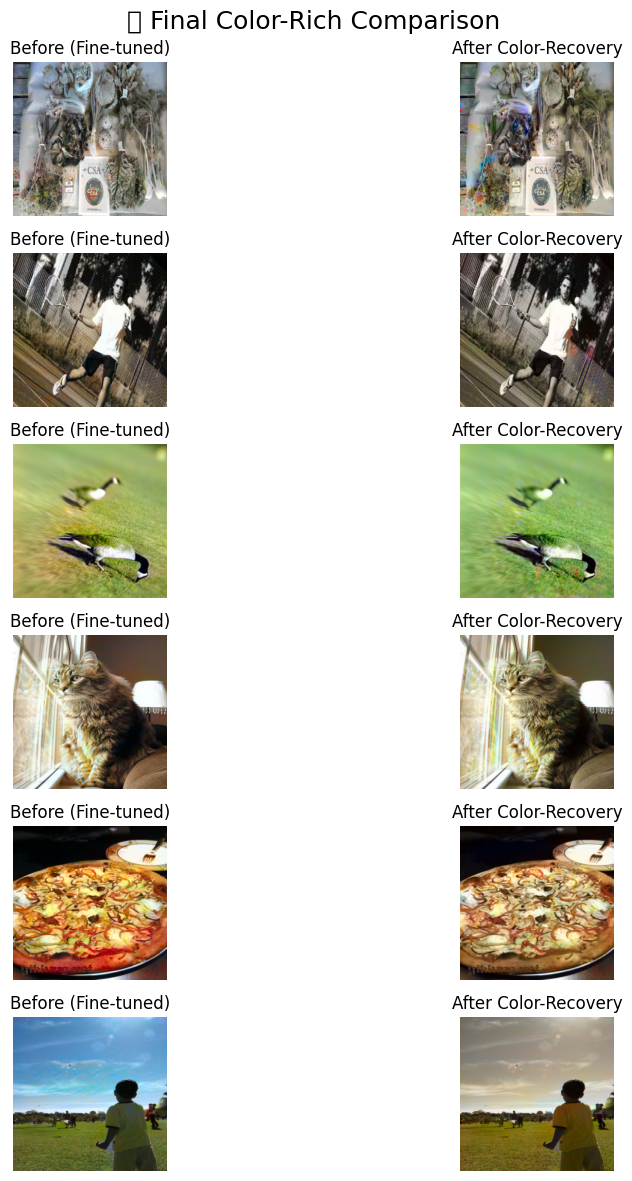

In [38]:
import matplotlib.pyplot as plt, numpy as np, cv2, torch

def lab_to_rgb_np(L, ab):
    lab = np.concatenate([L[..., None], ab], axis=2).astype("float32")
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Load pre-recovery generator (epoch_69_final_finetuned)
G_prev = G.__class__()  # same architecture
G_prev.load_state_dict(torch.load(CHECKPOINT_DIR / "fine_epoch_10.pth", map_location="cpu")["G"])
G_prev = G_prev.to(device).eval()

# Current G = color-recovered
G.eval()

# Pick 6 validation samples
L_edge, ab_true = next(iter(train_dl))
L_edge = L_edge[:6].to(device)

with torch.no_grad():
    ab_pred_prev  = G_prev(L_edge).cpu()
    ab_pred_final = G(L_edge).cpu()

plt.figure(figsize=(12,12))
for i in range(6):
    L = (L_edge[i,0].cpu().numpy() * 100)
    ab1 = (ab_pred_prev[i].numpy().transpose(1,2,0) * 255) - 128
    ab2 = (ab_pred_final[i].numpy().transpose(1,2,0) * 255) - 128
    rgb1 = np.clip(lab_to_rgb_np(L, ab1),0,1)
    rgb2 = np.clip(lab_to_rgb_np(L, ab2),0,1)

    plt.subplot(6,2,2*i+1); plt.imshow(rgb1); plt.axis("off"); plt.title("Before (Fine-tuned)")
    plt.subplot(6,2,2*i+2); plt.imshow(rgb2); plt.axis("off"); plt.title("After Color-Recovery")
plt.suptitle("🎨 Final Color-Rich Comparison", fontsize=18)
plt.tight_layout()
plt.show()

In [14]:
# Step 1 — Load your best performing model (epoch 69)
import torch
from pathlib import Path
CHECKPOINT_DIR = ROOT / "checkpoints"
ckpt_path = CHECKPOINT_DIR / "fine_epoch_10.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

G.load_state_dict(checkpoint["G"])
G.eval()

print("✅ Loaded best model: epoch_69_final_finetuned.pth (epoch 69)")

✅ Loaded best model: epoch_69_final_finetuned.pth (epoch 69)


In [15]:
# Step 2 — Create validation dataloader (if not yet defined)
val_ds = CocoColorizationDatasetSafe(split="val")
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Validation dataset loaded: {len(val_ds)} samples")

✅ Validation dataset loaded: 5000 samples


In [16]:
print(next(G.parameters()).device)

cuda:0


C:\Users\Ayush\AppData\Local\Temp\ipykernel_46912\3725678525.py:78: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Ayush\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


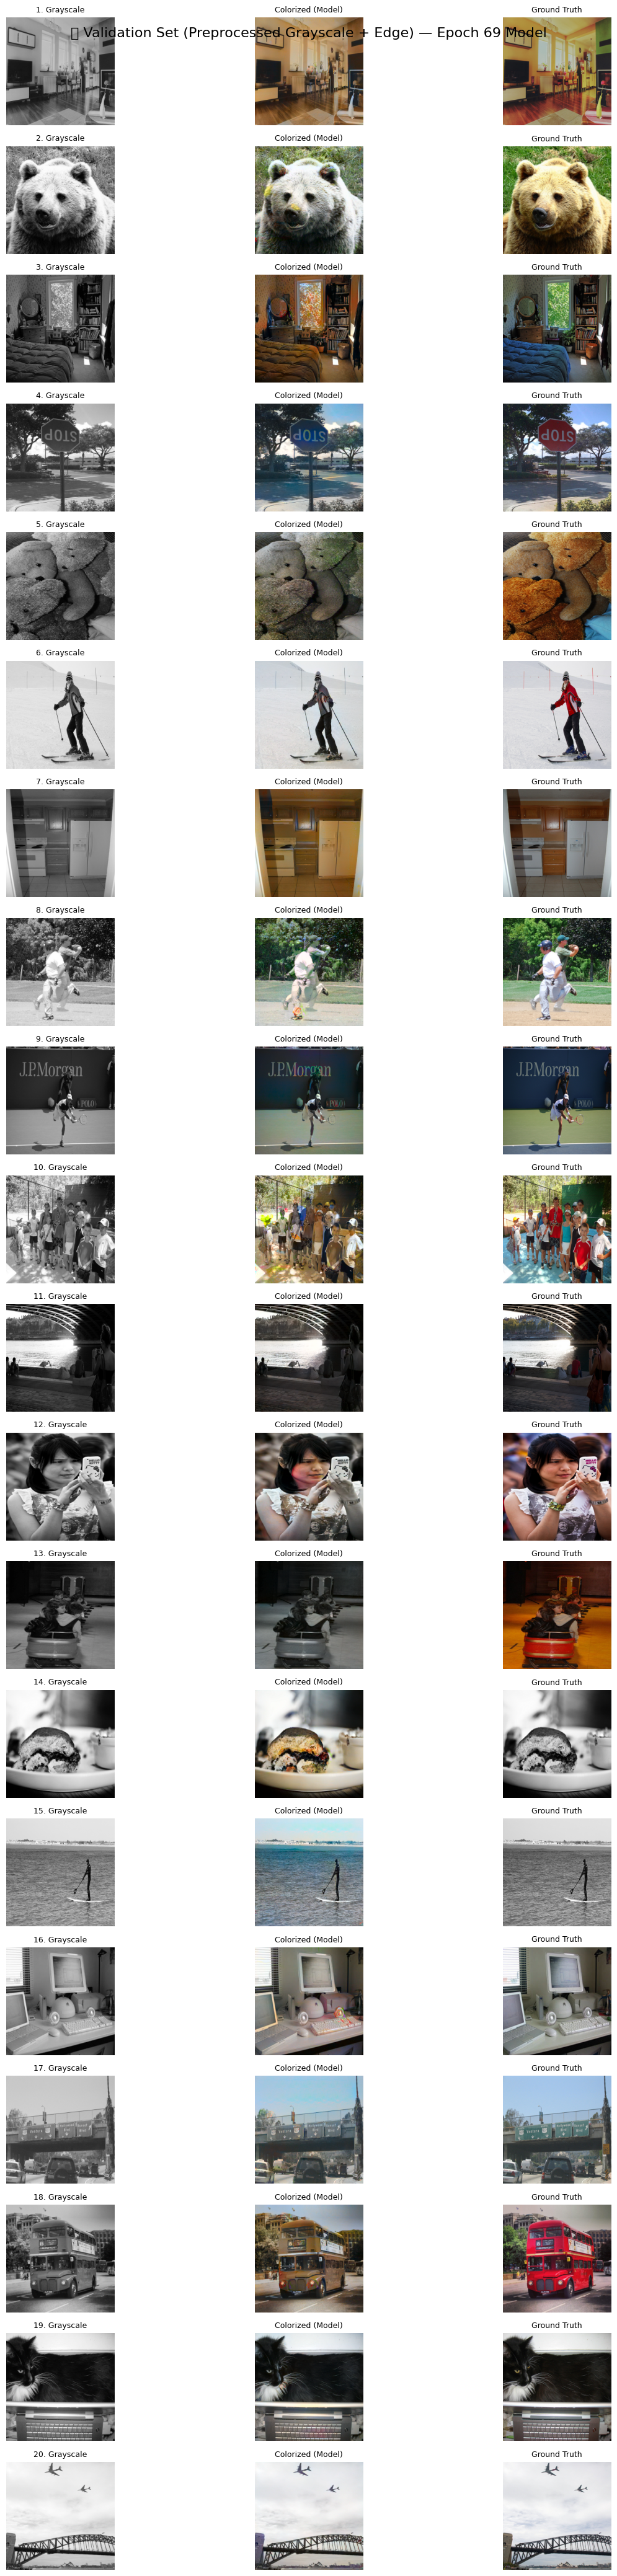

In [17]:
# ⚡ Validation Visualization — Uses Pre-Saved Grayscale and Edge Maps
import os, cv2, torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ───────────────────────────────
# Model setup
# ───────────────────────────────
G = G.to(device)
G.eval()

# ───────────────────────────────
# Helper: LAB → RGB conversion
# ───────────────────────────────
def lab_to_rgb_np(L, ab):
    lab = np.concatenate([L[..., None], ab], axis=2).astype("float32")
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# ───────────────────────────────
# Folder paths
# ───────────────────────────────
rgb_dir  = ROOT / "val2017"
gray_dir = ROOT / "grayscale" / "val"
edge_dir = ROOT / "edges" / "val"

# Collect file names (ensure sorted alignment)
files = sorted([f for f in os.listdir(rgb_dir) if f.endswith((".jpg", ".jpeg", ".png"))])
sample_files = files[:20]   # visualize first 20 val samples

# ───────────────────────────────
# Process and visualize
# ───────────────────────────────
plt.figure(figsize=(14, 42))

for i, fname in enumerate(sample_files):
    stem = os.path.splitext(fname)[0]

    # Load pre-saved grayscale & edge
    gray_path = gray_dir / f"{stem}_L.png"
    edge_path = edge_dir / f"{stem}_edge.png"

    # Skip missing files safely
    if not os.path.exists(gray_path) or not os.path.exists(edge_path):
        continue

    # Load original RGB, grayscale, edge
    rgb = np.array(Image.open(rgb_dir / fname).convert("RGB").resize((256, 256)))
    gray = np.array(Image.open(gray_path).convert("L").resize((256, 256)))
    edge = np.array(Image.open(edge_path).convert("L").resize((256, 256)))

    # Prepare L & edge tensors
    L = gray / 255.0
    inp = torch.tensor(np.stack([L, edge / 255.0], axis=0)).unsqueeze(0).to(device).float()

    # Predict ab channels
    with torch.no_grad():
        ab_pred = G(inp).cpu().squeeze(0).numpy().transpose(1, 2, 0)

    # Convert back to RGB
    L_lab = (L * 100)
    ab_pred = (ab_pred * 255) - 128
    rgb_pred = np.clip(lab_to_rgb_np(L_lab, ab_pred), 0, 1)
    rgb_true = rgb / 255.0
    gray_3ch = np.repeat(L[..., None], 3, axis=2)

    # Plot
    plt.subplot(20, 3, 3 * i + 1)
    plt.imshow(gray_3ch, cmap='gray'); plt.axis("off"); plt.title(f"{i+1}. Grayscale", fontsize=9)

    plt.subplot(20, 3, 3 * i + 2)
    plt.imshow(rgb_pred); plt.axis("off"); plt.title("Colorized (Model)", fontsize=9)

    plt.subplot(20, 3, 3 * i + 3)
    plt.imshow(rgb_true); plt.axis("off"); plt.title("Ground Truth", fontsize=9)

plt.suptitle("🎨 Validation Set (Preprocessed Grayscale + Edge) — Epoch 69 Model", fontsize=16)
plt.tight_layout()
plt.show()

In [24]:
# Step 1 — Install LPIPS (for perceptual similarity)
!pip install lpips


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import torch
import torch.nn.functional as F
import lpips
from skimage.metrics import structural_similarity as ssim
from math import log10
import numpy as np, cv2
from tqdm import tqdm

In [19]:
# SSIM and PSNR helpers
def calc_ssim(img1, img2):
    return ssim(img1, img2, channel_axis=-1, data_range=1.0)

def calc_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    return 10 * log10(1.0 / mse) if mse > 0 else 100

In [20]:
# Step 3 — Evaluate model on validation data
G.eval()
lpips_alex = lpips.LPIPS(net='alex').to(device)

ssim_scores, psnr_scores, lpips_scores = [], [], []

# Evaluate on 200 random val samples to save time
val_subset = torch.utils.data.Subset(val_ds, np.random.choice(len(val_ds), 200, replace=False))
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=0)

print("🔍 Evaluating model performance on 200 val samples...")

for L_edge, ab_true in tqdm(val_loader):
    L_edge, ab_true = L_edge.to(device), ab_true.to(device)
    with torch.no_grad():
        ab_pred = G(L_edge)

    # Convert LAB → RGB
    for i in range(L_edge.size(0)):
        L = (L_edge[i,0].cpu().numpy() * 100)
        ab_p = (ab_pred[i].cpu().numpy().transpose(1,2,0) * 255) - 128
        ab_t = (ab_true[i].cpu().numpy().transpose(1,2,0) * 255) - 128

        rgb_pred = np.clip(cv2.cvtColor(np.concatenate([L[...,None], ab_p], axis=2).astype("float32"), cv2.COLOR_LAB2RGB), 0, 1)
        rgb_true = np.clip(cv2.cvtColor(np.concatenate([L[...,None], ab_t], axis=2).astype("float32"), cv2.COLOR_LAB2RGB), 0, 1)

        # SSIM / PSNR (NumPy)
        ssim_scores.append(calc_ssim(rgb_pred, rgb_true))
        psnr_scores.append(calc_psnr(rgb_pred, rgb_true))

        # LPIPS (Tensor)
        pred_t = torch.tensor(rgb_pred).permute(2,0,1).unsqueeze(0).to(device)
        true_t = torch.tensor(rgb_true).permute(2,0,1).unsqueeze(0).to(device)
        lpips_scores.append(lpips_alex(pred_t, true_t).item())

# Mean metrics
print(f"\n✅ SSIM mean: {np.mean(ssim_scores):.4f}")
print(f"✅ PSNR mean: {np.mean(psnr_scores):.2f} dB")
print(f"✅ LPIPS mean: {np.mean(lpips_scores):.4f}  (↓ lower is better)")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


C:\Users\Ayush\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ayush\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\Ayush\myenv\lib\site-packages\lpips\weights\v0.1\alex.pth
🔍 Evaluating model performance on 200 val samples...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


✅ SSIM mean: 0.8814
✅ PSNR mean: 22.09 dB
✅ LPIPS mean: 0.1408  (↓ lower is better)
